In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.utils.prune as prune

from copy import deepcopy

In [2]:
torch.manual_seed(0);

In [3]:
# base linear block
class SparseLinear(nn.Module):
    """
    Sparse linear layer with MAIN weight and bias matrices.

    Args:
        weight (torch.sparse.FloatTensor): The sparse weight matrix.
        bias (torch.sparse.FloatTensor): The sparse bias vector.

    Methods:
        forward(input):
            Performs the forward pass of the layer.
            Args:
                input (torch.Tensor): Input tensor to the layer.
            Returns:
                torch.Tensor: Output tensor after applying the sparse linear transformation.
    """

    def __init__(self, weight: torch.sparse.FloatTensor, bias: torch.sparse.FloatTensor):
        super(SparseLinear, self).__init__()

        # sparse weight
        self.weight_indices = weight.coalesce().indices()
        self.weight_values = nn.Parameter(weight.coalesce().values())
        self.weight_size = list(weight.coalesce().size())

        # sparse bias
        # todo: think about bias representation
        self.bias_indices = bias.coalesce().indices()
        self.bias_values = nn.Parameter(bias.coalesce().values())
        self.bias_size = list(bias.coalesce().size())

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        # create real sparse weight and bias
        # weight in separated form needed for optimizer
        sparse_weight = torch.sparse.FloatTensor(self.weight_indices, self.weight_values, self.weight_size)
        sparse_bias = torch.sparse.FloatTensor(self.bias_indices, self.bias_values, self.bias_size).to_dense()

        output = torch.sparse.mm(sparse_weight, input.t()).t()
        output += sparse_bias.unsqueeze(0)

        return output

In [4]:
def dense_to_sparse(dense_tensor: torch.Tensor) -> torch.sparse.FloatTensor:
    indices = dense_tensor.nonzero(as_tuple=True)
    values = dense_tensor[indices]
    indices = torch.stack(indices)

    sparse_tensor = torch.sparse.FloatTensor(indices, values, dense_tensor.size())
    return sparse_tensor

In [5]:
def convert_dense_to_sparse_network(model: nn.Module) -> nn.Module:
    """
    Converts a given dense neural network model to a sparse neural network model.

    This function recursively iterate through the given model and replaces all instances of 
    `nn.Linear` layers with `SparseLinear` layers

    Args:
        model (nn.Module): The dense neural network model to be converted.

    Returns:
        nn.Module: A new neural network model with sparse layers.
    """
    new_model = model.__class__()

    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            sparse_weight = dense_to_sparse(module.weight.data)
            sparse_bias = dense_to_sparse(module.bias.data)

            setattr(new_model, name, SparseLinear(sparse_weight, sparse_bias))
        else:
            setattr(new_model, name, convert_dense_to_sparse_network(module))
    return new_model

### SparseRecursiveLinear
##### algorithm of replace method
1) remove edge from MAIN weight
2) add new weight to the end of MAIN weight
3) add new weight to embed weight
##### algorithm of forward
1) recursive iterating through layers:
    - create real sparse
    - pass through embed weight
    - concat input with output
2) pass concatenated with embed outputs input through MAIN layer

In [6]:
class SparseRecursiveLinear(nn.Module):
    """
    Sparse recursive linear layer.

    Args:
        sparse_linear (nn.Module): The sparse MAIN linear layer.
        previous (SparseRecursiveLinear or None): The previous layer in the recursive chain.
        is_last (bool, optional): Flag indicating if this is the last layer. Default is False.

    Methods:
        replace(child, parent):
            Replace an edge between two nodes in the layer to new node and two edges.
            Updates weight of MAIN layer and self embed weights.

        forward(input):
            Forward pass through all previous layers and the MAIN layer.
    """
    def __init__(self, sparse_linear, previous, is_last=False):
        super(SparseRecursiveLinear, self).__init__()
        self.sparse_linear = sparse_linear
        self.previous = previous
        self.is_last = is_last

        self.embed_weight_indeces = torch.empty(2, 0, dtype=torch.int)
        self.embed_weight_values = nn.Parameter(torch.empty(0))
        self.embed_weight_size = torch.tensor([0, self.sparse_linear.weight_size[1]])

        self.child_counter = 0


    def replace(self, child, parent):
        # mask of edge to remove in MAIN weight
        matches = (self.sparse_linear.weight_indices[0] == child) &\
                  (self.sparse_linear.weight_indices[1] == parent)
        index_to_remove = matches.nonzero(as_tuple=True)[0] # index of edge to remove in MAIN weight

        self.sparse_linear.weight_indices = self.sparse_linear.weight_indices[:, torch.logical_not(matches)] # remove edge from MAIN weight by masking

        # concated input from embed weight will pass through last vertices in MAIN layer
        max_parent = self.sparse_linear.weight_indices[1].max() + 1 # increase number of nodes in "input" of MAIN layer
        self.sparse_linear.weight_indices = torch.cat([self.sparse_linear.weight_indices, torch.tensor([[child, max_parent]]).t()], dim=1) # add new edge to MAIN weight

        value_to_remove = self.sparse_linear.weight_values[index_to_remove] # get value of deleted edge from MAIN weight
        self.sparse_linear.weight_values.data = self.sparse_linear.weight_values[self.sparse_linear.weight_values != value_to_remove] # remove value of deleted edge from MAIN value list
        # todo smart weight generation
        self.sparse_linear.weight_values.data = torch.cat([self.sparse_linear.weight_values.data, torch.rand(1)]) # add new random weight to end of MAIN value list

        self.sparse_linear.weight_size[1] += 1 # increase number of nodes in "input" of MAIN layer

        # add new edge to embed weight
        # where self.child_counter is number of nodes in embed weight
        # and parent is number of input node
        self.embed_weight_indeces = torch.cat([self.embed_weight_indeces, torch.tensor([[self.child_counter, parent]]).t()], dim=1)
        # todo smart weight generation
        self.embed_weight_values.data = torch.cat([self.embed_weight_values, torch.rand(1)]) # add new random weight to end of embed value list
        self.embed_weight_size[0] += 1
        self.child_counter += 1

    def forward(self, input):
        # if previous layer exists pass input through prevuios layer
        if self.previous is not None:
            input = self.previous.forward(input)
        # else pass through self weight

        # create real sparse weight
        sparse_embed_weight = torch.sparse.FloatTensor(
            self.embed_weight_indeces,
            self.embed_weight_values,
            list(self.embed_weight_size)
        )
        # pass thourgh self weight
        output = torch.sparse.mm(sparse_embed_weight, input.t()).t()
        # concat output of embed weight and input
        input = torch.cat([input, output], dim=1)
        
        # pass through MAIN weight if it's last recursive layer
        if self.is_last:
            return self.sparse_linear(input)

        return input

In [7]:
class SimpleFCN(nn.Module):
    def __init__(self, input_size=8):
        super(SimpleFCN, self).__init__()
        self.fc1 = nn.Linear(input_size, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(2, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleFCN()

In [8]:
sparse_model = convert_dense_to_sparse_network(model)

/var/folders/j3/pkh9dw6j2jz20w5kf6q4j47c0000gn/T/ipykernel_33192/2826168304.py:6: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:607.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, dense_tensor.size())


In [9]:
sparse_linear = deepcopy(sparse_model.fc1)

In [10]:
sparse_putting_linear1 = SparseRecursiveLinear(sparse_linear, None)
print(sparse_putting_linear1.sparse_linear.weight_indices, "\n")
sparse_putting_linear1.replace(1, 6)
sparse_putting_linear1.replace(1, 7)
sparse_putting_linear1.replace(2, 6)
print(sparse_putting_linear1.sparse_linear.weight_indices)
print(sparse_putting_linear1.embed_weight_indeces, "\n")

sparse_putting_linear2 = SparseRecursiveLinear(sparse_linear, sparse_putting_linear1)
sparse_putting_linear2.replace(1, 8)
sparse_putting_linear2.replace(2, 10)
print(sparse_putting_linear1.sparse_linear.weight_indices)
print(sparse_putting_linear2.embed_weight_indeces, "\n")

sparse_putting_linear3 = SparseRecursiveLinear(sparse_linear, sparse_putting_linear2, is_last=True)
sparse_putting_linear3.replace(1, 11)
print(sparse_putting_linear1.sparse_linear.weight_indices)
print(sparse_putting_linear3.embed_weight_indeces, "\n")


tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
         3, 3, 3, 3, 3, 3, 3, 3],
        [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
         0, 1, 2, 3, 4, 5, 6, 7]]) 

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,
          2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  1,  1,  2],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  0,  1,  2,  3,  4,  5,  0,  1,  2,  3,
          4,  5,  7,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])
tensor([[0, 1, 2],
        [6, 7, 6]]) 

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,
          2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  1,  1,  2],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  0,  1,  2,  3,  4,  5,  0,  1,  2,  3,
          4,  5,  7,  0,  1,  2,  3,  4,  5,  6,  7,  9, 11, 12]])
tensor([[ 0,  1],
        [ 8, 10]]) 

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,
          2,  2,

1 and 4 values is same because we change only edges, which go to 2 and 3 output

In [11]:
x = torch.rand(1, 8)
sparse_model.fc1(x)

tensor([[-0.2391, -0.6336,  0.1473, -0.5930]], grad_fn=<AsStridedBackward0>)

In [12]:
sparse_putting_linear3(x)

tensor([[-0.2391, -0.3943,  0.2211, -0.5930]], grad_fn=<AsStridedBackward0>)

In [13]:
import torch
import torch.nn as nn
from torchviz import make_dot
sample_input = torch.randn(1, 8)

putted_output = sparse_putting_linear3(sample_input)
simple_output = sparse_model.fc1(sample_input)

putted_graph = make_dot(putted_output, params=dict(sparse_putting_linear3.named_parameters()))
simple_graph = make_dot(simple_output, params=dict(sparse_model.fc1.named_parameters()))

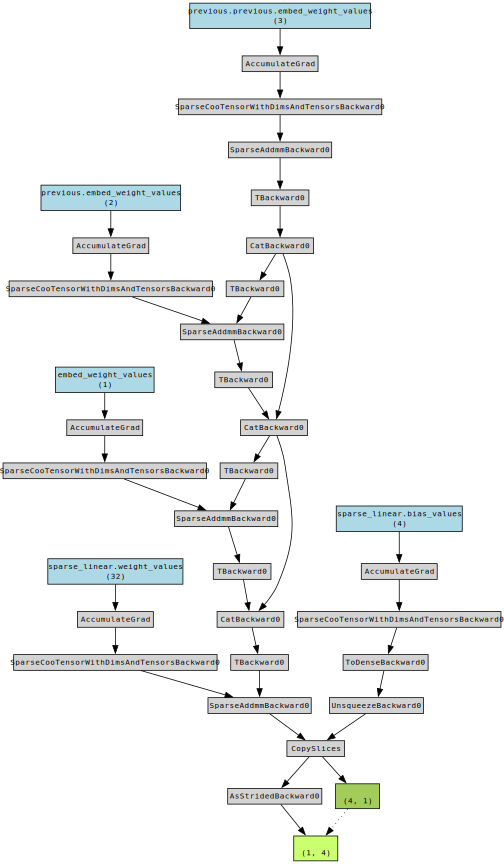

In [14]:
putted_graph

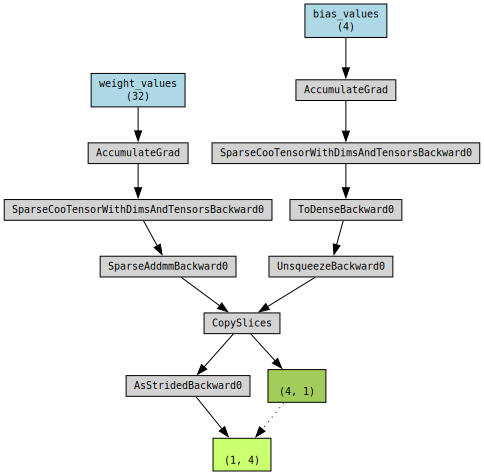

In [15]:
simple_graph